In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from numba import jit, cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float64
import math

In [2]:
!nvidia-smi

Thu Sep 14 04:55:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
start = time.time()

In [4]:
#define some variable
history = 200
dummy_history = 2000 #active dan dummy particles are 35000
radius = 5 #cylinder radius
fr = np.float64(1) #fuel radius must be float64 (need when CUDA do calculation)
speed = 1
fps = 20
dt = 1/fps
final_time = 200
steps = int(final_time/dt) #simulation step

In [5]:
#define how many threads per block and block size
threads_per_block = 300
blocks = (dummy_history+threads_per_block-1) // threads_per_block
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

In [6]:
#initialize particle location
r_host = np.float64(np.full((dummy_history, 2), -11000))
r = cuda.to_device(r_host) #send to device
@cuda.jit #decorator for CUDA
def initialize_particles(rng_states, r, history):
    thread_id = cuda.grid(1) #only 1 dimension data to be spread
    if thread_id < history:
        teta = xoroshiro128p_uniform_float64(rng_states, thread_id)*2*np.pi #CUDA doesn't know np.random
        position = xoroshiro128p_uniform_float64(rng_states, thread_id)*radius
        r[thread_id, 0] = position * math.sin(teta)
        r[thread_id, 1] = position * math.cos(teta)
initialize_particles[blocks, threads_per_block](rng_states, r, history)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [7]:
#initialize record data
record_host = np.float64(np.full((steps, dummy_history, 2), -11000)) #because CUDA doesn't know nan value, we need give fake value
record_host[0,:,:] = r_host[:,:] #for the first step, copy the position of particle initialization
record = cuda.to_device(record_host)

In [8]:
#initialize fuel
fuel_host = np.full((1, 2), np.nan)
def initialize_fuel(fuel_host):
    fuel_host[0, 0] = 0
    fuel_host[0, 1] = 0
initialize_fuel(fuel_host)
fuel = cuda.to_device(fuel_host)

In [9]:
#initialize particle speed
v_host = np.float64(np.full((dummy_history, 2), 0))
v = cuda.to_device(v_host)
@cuda.jit
def initialize_speed(rng_states, v, history):
    thread_id = cuda.grid(1)
    if thread_id < history:
        teta = xoroshiro128p_uniform_float64(rng_states, thread_id)*2*np.pi
        v[thread_id, 0] = speed * math.cos(teta)
        v[thread_id, 1] = speed * math.sin(teta)
initialize_speed[blocks, threads_per_block](rng_states, v, history)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [10]:
#update particle position and speed and update record (all particles)
@cuda.jit
def update_particle1(i, dummy_history, r, v, fuel, fr, collision, record):
    thread_id = cuda.grid(1)
    if thread_id < dummy_history:
        if r[thread_id, 0] == -11000 or r[thread_id, 0] == 11000: #if it is a dummy particle
            pass
        elif (fuel[0, 0] - fr <= r[thread_id, 0] <= fuel[0, 0] + fr and
              fuel[0, 1] - fr <= r[thread_id, 1] <= fuel[0, 1] + fr and
              math.sqrt(r[thread_id, 0]**2 + r[thread_id, 1]**2) <= fr): #if collide with fuel
            r[thread_id,:] = 11000 #if it collide with fuel, it will be gone (give fake number)
            v[thread_id,:] = 0 #its velocity also must be 0 to keep the particle at 11000
            collision[thread_id] = 1 #the mark if collision happen
        elif math.sqrt(r[thread_id, 0]**2 + r[thread_id, 1]**2) < radius: #if it inside the domain
            for k in range(r.shape[1]):
                r[thread_id, k] = r[thread_id, k] + v[thread_id, k] * np.float64(dt)
        else: #if it hit the boundary of the cylinder
            distance_to_origin = math.sqrt(r[thread_id, 0]**2 + r[thread_id, 1]**2)
            normal_vectorx = r[thread_id, 0] / distance_to_origin
            normal_vectory = r[thread_id, 1] / distance_to_origin
            dot_product = v[thread_id, 0] * normal_vectorx + v[thread_id, 1] * normal_vectory
            v[thread_id, 0] -= 2 * dot_product * normal_vectorx
            v[thread_id, 1] -= 2 * dot_product * normal_vectory
            for k in range(r.shape[1]):
                r[thread_id, k] = r[thread_id, k] + v[thread_id, k] * np.float64(dt)
        for j in range(2):
            record[i,thread_id,j] = r[thread_id,j]

In [11]:
#change 2 dummies particle into active particle (proccess in CPU)
@jit(nopython=True)
def update_particle2(r_host, v_host):
    born_part = 2 #will produce 2 active particle
    for i in range(dummy_history):
        if born_part == 0:
            break
        if v_host[i,0] == 0.:
            teta = np.random.uniform(0, 2*np.pi)
            position = np.random.uniform(0, radius)
            r_host[i, 0] = position * math.sin(teta) #ramdomized position
            r_host[i, 1] = position * math.cos(teta)
            teta = np.random.uniform(0, 2*np.pi)
            v_host[i, 0] = speed * np.cos(teta) #randomized velocity
            v_host[i, 1] = speed * np.sin(teta)
            born_part = born_part-1
        else: continue

In [12]:
#the main loop of the program
for i in range(1,steps):
    collision_host = np.full((dummy_history), 0) #collision is set to 0
    collision = cuda.to_device(collision_host)
    update_particle1[blocks, threads_per_block](i, dummy_history, r, v, fuel, fr, collision, record) #program to be run on CUDA
    collision_host = collision.copy_to_host() #getting the information about collision from CUDA to CPU
    r_host = r.copy_to_host() #copy the result into CPU
    v_host = v.copy_to_host()
    for k in range(dummy_history): #change the pasive particle into active particle based on how many collision happen
        if collision_host[k] == 1:
            update_particle2(r_host, v_host) #add more active particle
    r = cuda.to_device(r_host)
    v = cuda.to_device(v_host)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [13]:
record_host = record.copy_to_host() #get the last result into CPU

In [14]:
end = time.time()
print(f'duration = {end-start}')

duration = 10.558335781097412


In [15]:
#calculate how many particle are produced
part = 0
for i in range(dummy_history):
    if record_host[3999,i,0] != 11000 and record_host[3999,i,0] != -11000:
        part +=1
print('Particles =', part)

Particles = 655


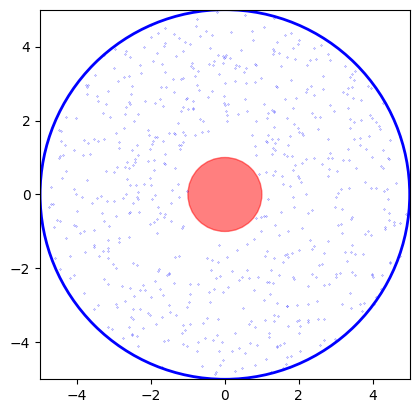

In [16]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_aspect('equal')

# Create a scatter plot for the particles with a specified size (e.g., ms=2)
particles, = ax.plot([], [], 'bo', ms=0.2)

# Create cylinder boundary
cylinder = plt.Circle((0, 0), radius, color='b', fill=False, lw=2)
ax.add_patch(cylinder)

# Create fuel region
fuel_region = plt.Circle((0, 0), fr, color='red', alpha=0.5)
ax.add_patch(fuel_region)

# Function to initialize the plot
def init():
    particles.set_data([], [])
    return particles,

# Function to update particle positions for each frame
def update(frame):
    x_data = record_host[frame,:,0].copy()
    y_data = record_host[frame,:,1].copy()
    particles.set_data(x_data, y_data)
    return particles,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(record_host), init_func=init, interval=50, blit=True)

# Set up the animation writer for MP4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation as an MP4 file
ani.save('particle_animation.mp4', writer=writer)

# Display the animation
plt.show()